###PUI-HW5-Buidling Energy

In [24]:
import geopandas as gp
import pandas as pd
import numpy as np
import os
import json
import pylab as pl
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm
s = json.load( open(os.getenv('PUI2015')+'/ylai_matplotlibrc.json') )
pl.rcParams.update(s)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


###We will use 2 different datasets.
An interesting urban question is "can we measure and predict energy use based on observables that are easier to be acquired". for example the urban observatory at CUSP can monitor lights: they are a realtively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.

so let's test if the last link holds. If we have data on the energy consumed by a __building__ how well does that relate to the number of units in the building?

### data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  

In [2]:
##Reading Local Law 84 Dataset for building energy consumption.
nrg = gp.GeoDataFrame.from_csv("Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv")
print nrg.columns

Index([u'NYC Borough, Block, and Lot (BBL)', u'Co-reported BBL Status',
       u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
       u'Street Number', u'Street Name', u'Borough', u'Zip Code',
       u'DOF Benchmarking Submission Status', u'Site EUI(kBtu/ft2)',
       u'Weather Normalized Site EUI(kBtu/ft2)', u'Source EUI(kBtu/ft2)',
       u'Weather Normalized Source EUI(kBtu/ft2)',
       u'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       u'Automatic Water Benchmarking Eligible', u'Reported Water Method',
       u'ENERGY STAR Score', u'Total GHG Emissions(MtCO2e)',
       u'Direct GHG Emissions(MtCO2e)', u'Indirect GHG Emissions(MtCO2e)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'Primary Property Type - Self Selected', u'DOF Number of Buildings'],
      dtype='object')


However this datasets does not have the number of units. We can find that in the Pluto dataset.
Reading in the Pluto data for manhattan, which will give me the number of units ber building   Manhattan/MNMapPLUTO.shp

In [3]:
##Read PLUTO dataset for number of units and other information.
bsize = gp.GeoDataFrame.from_file("Manhattan/MNMapPLUTO.shp")
print bsize.columns

Index([    u'APPBBL',    u'APPDate',    u'Address', u'AllZoning1',
       u'AllZoning2', u'AreaSource', u'AssessLand',  u'AssessTot',
              u'BBL',   u'BldgArea',  u'BldgClass',  u'BldgDepth',
        u'BldgFront',      u'Block',   u'BoroCode',    u'Borough',
         u'BsmtCode',  u'BuiltCode',   u'BuiltFAR',     u'CB2010',
               u'CD',     u'CT2010',    u'ComArea',    u'CommFAR',
          u'CondoNo',    u'Council',  u'EDesigNum',  u'Easements',
       u'ExemptLand',  u'ExemptTot',        u'Ext',   u'FacilFAR',
       u'FactryArea',   u'FireComp', u'GarageArea', u'HealthArea',
         u'HistDist', u'IrrLotCode',    u'LandUse',   u'Landmark',
              u'Lot',    u'LotArea',   u'LotDepth',   u'LotFront',
          u'LotType',  u'LtdHeight', u'MAPPLUTO_F',   u'NumBldgs',
        u'NumFloors', u'OfficeArea',  u'OtherArea',   u'Overlay1',
         u'Overlay2',  u'OwnerName',  u'OwnerType', u'PLUTOMapID',
       u'PolicePrct',   u'ProxCode',    u'ResArea',   u'ResidF

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12dbae790>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x127ac6690>]], dtype=object)

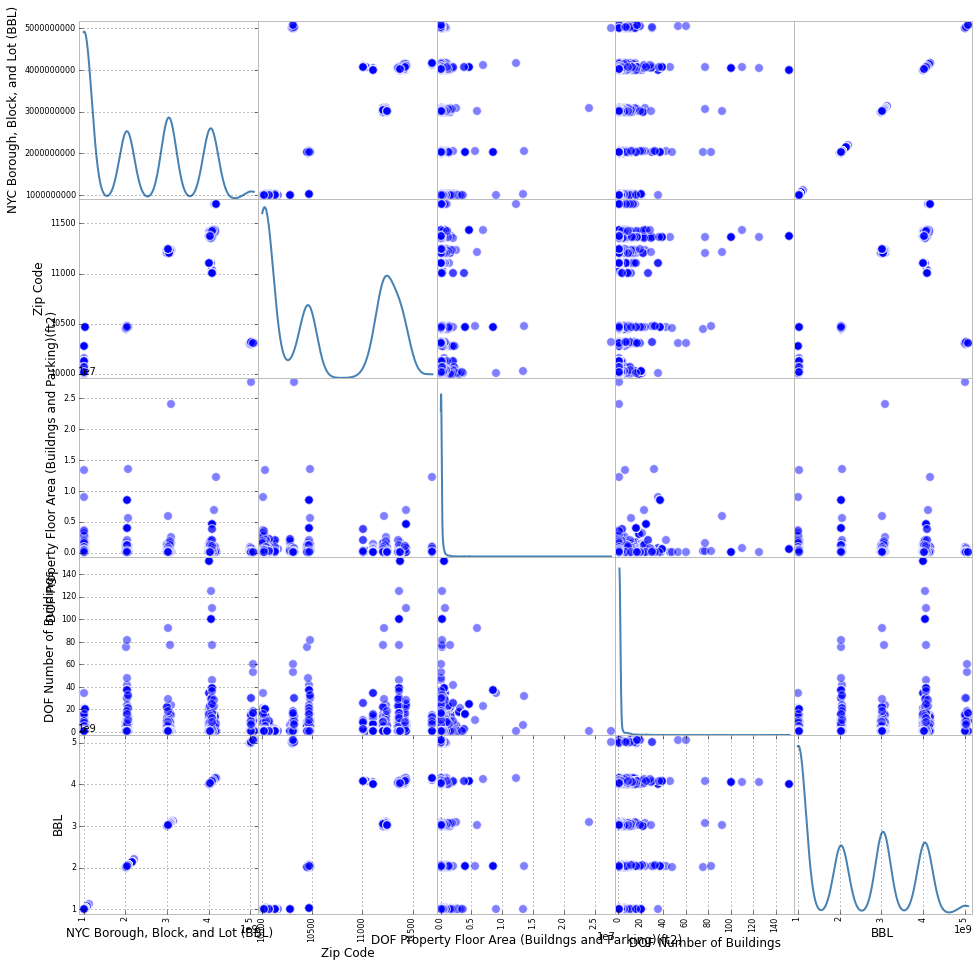

In [25]:
##In pandas scatter_matrix will plot each column agains each other. 
##This is a great way to begin inspecting your data (though be careful cause it is computationally comsuming for large datasets). 
from pandas.tools.plotting import scatter_matrix
scatter_matrix (nrg, s=300, figsize=(16, 16), diagonal='kde')

It will show me correlations between variables, but it will also show me what can and 
cannot be plotted trivially in my dataset! here only a few columns can be plotted: 
those that contain only numbers (and possibly NaN's), but most columns contain rows that cannot be converted to float (e.g. entries like 'See Primary BBL' in several rows for the energy dataframe 'Site EUI(kBtu/ft2) ' column) , so Pandas refuses to plot them, cause it does not know what to do with those entries. 
The columns I am interested in are in fact u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg.       u'Reported Property Floor Area (Building(s)) (ft²)'. Neither gets plotted: I need to remove all values that cannot conver to float in order to use the columns and convert them to float arrays and do math with them. 

Below I created a function that returns True if what is passed as argument can be converted to a float, and False otherwise. I do it with the Try/Except structure. it is a very useful python functionality that you should look into.  
this has to be done entry by entry: if you give it a series you get error "cannot convert the series to <type 'float'>"

However you can pass it a whole array by using it in conjunction with
__np.vectorize__ (look up the syntax!) which will implement a for loop for you under the hood to pass the series entry by entry to your function.


In [5]:
def canconvert(mydata):
    try :
        float(mydata)
        return True
    except ValueError:
        return False   

In [31]:
#create the indeces array here
indx1 = np.vectorize(canconvert)(nrg['Site EUI(kBtu/ft2)'])
indx2 = np.vectorize(canconvert)(bsize['BBL'])
indx3 = np.vectorize(canconvert)(nrg['Reported Property Floor Area (Building(s)) (ft²)'])

In [30]:
nrg['Site EUI(kBtu/ft2)'][~indx1]=float('NaN')
bsize['BBL'][~indx2]=float('NaN')
nrg['Reported Property Floor Area (Building(s)) (ft²)'][~indx3] = float('NaN')

/Users/ericlaibuffalo/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/ericlaibuffalo/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
/Users/ericlaibuffalo/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [32]:
##check that your conversion worked: e.g.
print nrg['Site EUI(kBtu/ft2)'].astype(float)[:10]
#[...] check all columns you care about in both datasets. 
#Nan's are ok, but you must not get an error when you try the conversion
#the Pluto data is much better at not using spurious entries for numerical value columns. 
#but check you can use the columns you want
print bsize.BBL.astype(float)[:10]
#notice I can use the attribute notation to refer to columns in bsize, 
#cause the column names do not have spaces!

Record Number
16099      180.5
500         82.1
5017       137.7
5116       103.2
363         74.0
6876        36.4
10714      114.8
1214       130.0
1544       138.3
1905     56909.0
Name: Site EUI(kBtu/ft2), dtype: float64
0    1002760020
1    1002280022
2    1005900056
3    1005890030
4    1005310056
5    1011860040
6    1004940026
7    1005580017
8    1001807505
9    1005820050
Name: BBL, dtype: float64


###Merge the Dataset:
To merge the datasets we need a common column: the building id __BBL__
However the name of this variable (column) in the Energy dataset is 'NYC Borough, Block, and Lot (BBL)'. Create a column 'BBL' in the nrg dataset to pass it to the 'on' keyword argument of the merge pandas method: pd.merge(..... on=['BBL']) will use the common column 'BBL' to join the information from the 2 datasets for each BBL value (check out the complete syntax!) 

In [48]:
nrg['BBL'] = nrg['NYC Borough, Block, and Lot (BBL)']
bblnrgdata = pd.merge(nrg, bsize, on='BBL', how = 'outer')

Now we want to plot __Energy vs Number of Units in the Building__. 
Remember: Energy TOTAL, not per sq ft...
Here you can choose what you think makes more sense for the number of units: all units, residential units...
make a 'natural' scale scatter plot first it will look really bad cause all the datapoints are at very low Unit numbers while the Unit number range actually goes up to 8000.
perhaps zoom into the region where most points are by cutting your x and y axis plotted: e,g, use xlim=(1000,1e10), ylim=(1,1000), where the numbers to be plugged in depend on exactly what you chose to plot

In [49]:
##Create a variable called "TotalEnergy" which is the Site EUI times Floor Area.
bblnrgdata['TotalEnergy']=bblnrgdata['Site EUI(kBtu/ft2)'].astype(float) * bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)'].astype(float)

In [50]:
bblnrgdata['TotalEnergy'][:10]

0    1.660022e+07
1    1.932388e+07
2    8.923786e+06
3    6.484985e+06
4    7.252000e+06
5    1.939210e+06
6    7.099921e+06
7    2.657421e+07
8    8.313213e+06
9    2.606125e+10
Name: TotalEnergy, dtype: float64

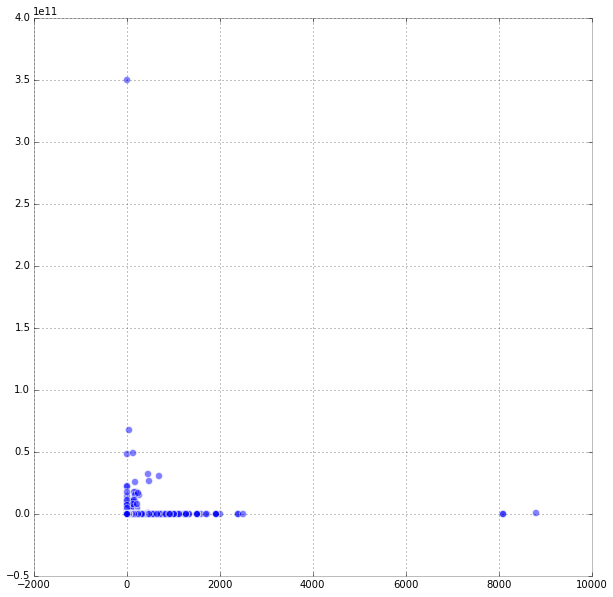

In [53]:
##Plot Total Energy vs. Number of Units:
pl.figure(figsize=(10,10))
#xlim = (1000,8000)
#ylim=(1,1000)
x = bblnrgdata['UnitsTotal']
y = bblnrgdata['TotalEnergy']
pl.scatter(x, y, alpha=.5, s=50)
pl.show()

when the points in a plot all look scrunched against the axis try a log plot! in pandas you enable that with the keyword 'loglog' :
bblnrgdata.plot(..... loglog=True)

NOTICE THAT YOU WILL STILL HAVE TO CUT YOUR DATASET! in my data i had a lot of energy datapoints that were exactly 0. I removed these "outliers" which I think are truly outliers in the sense that they are misreported numbers. you can remove the data that have nrg==0 (or nrg < some sensible threshold choice) by indexing your array:
something like bblnrgdata_cut = bblnrgdata[bblnrgdata.nrg>1000]

also i removed the buildings with several thousand units. points like that at the edge of my range would have a lot of "LEVERAGE", however  they are not suprious entries like the 0, which i believe are missing values, or perhaps abandoned lots. these are good datapoint that i need to throw away functionally for my analysis to work, but that should be stated clearly.


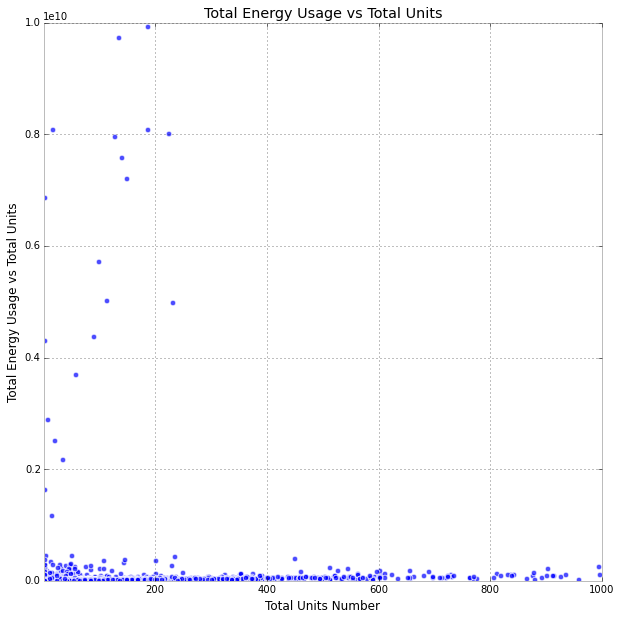

In [56]:
bblnrgdata_cut = bblnrgdata[(bblnrgdata['TotalEnergy']>1000) & (bblnrgdata['TotalEnergy']< 1e10) & (bblnrgdata['UnitsTotal']<1000)& (bblnrgdata['UnitsTotal']>1) ]
pl.figure(figsize=(10,10))

x = bblnrgdata_cut['UnitsTotal']
y = bblnrgdata_cut['TotalEnergy']
pl.xlim([1,1000])
pl.ylim([1000,1e10])

xlabel('Total Units Number')
ylabel('Total Energy Usage vs Total Units')
pl.title("Total Energy Usage vs Total Units")
pl.scatter(x, y, alpha=.7, s=30)
pl.show()

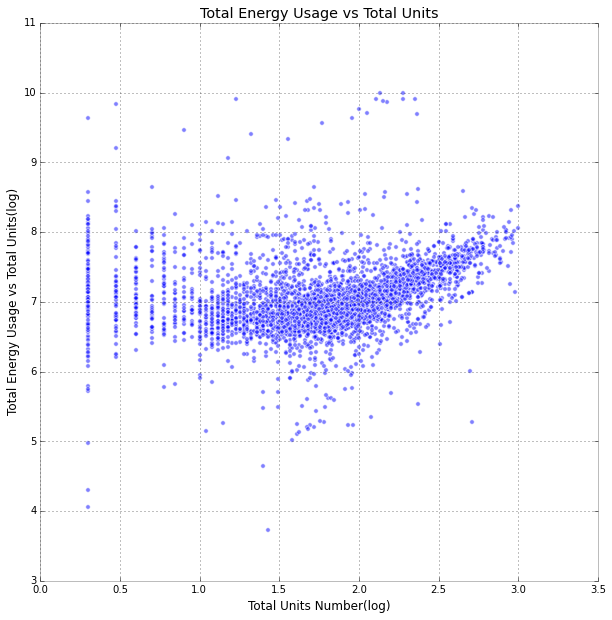

In [58]:
# Create log of Total Units and Total Energy.
Unit_log = np.log10(bblnrgdata_cut['UnitsTotal'])
Energy_log = np.log10(bblnrgdata_cut['TotalEnergy'])

# Plot the log of the two variables.
pl.figure(figsize=(10,10))
x = Unit_log 
y = Energy_log
#pl.xlim([1,1000])
#pl.ylim([1,200])

xlabel('Total Units Number(log)')
ylabel('Total Energy Usage vs Total Units(log)')
pl.title("Total Energy Usage vs Total Units")
pl.scatter(x, y, alpha=.5, s=20 )
pl.show()

Now fit a line through the data. We want to fit a line to the log of our variables, not the variables themselves.

In [59]:
X = sm.add_constant(x)
#print X
model = sm.OLS(y, X, missing='drop') # ignores entires where x or y is NaN
fit = model.fit()
fit.params[1], fit.params[0] # could also return stderr in each via fit.bse

(0.20624600657504538, 6.6599805405097188)

In [60]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            TotalEnergy   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     273.1
Date:                Wed, 14 Oct 2015   Prob (F-statistic):           1.24e-59
Time:                        12:12:53   Log-Likelihood:                -2827.3
No. Observations:                4609   AIC:                             5659.
Df Residuals:                    4607   BIC:                             5671.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.6600      0.023    287.564      0.000         6.615     6.705
UnitsTotal     0.2062      0.012     16.524      0.000         0.182     0.231
==============================================================================
Omnibus:                     1268.016   Durbin-Watson:                   1.567
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13298.270
Skew:                           1.006   Prob(JB):                         0.00
Kurtosis:                      11.074   Cond. No.                         8.30
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

remember to choose wisely which is your DEPENDENT and which is your INDEPENDENT variable. 
both for what you want to do logically (what changes as a functino of what) but also based on which  variable has a 'sensible' distribution that allows you to fit a function to it: 
    you need your independent variable to span a large range, and to be spread somewhat evenly in the range, 
    rather than just clustered in a spot
    


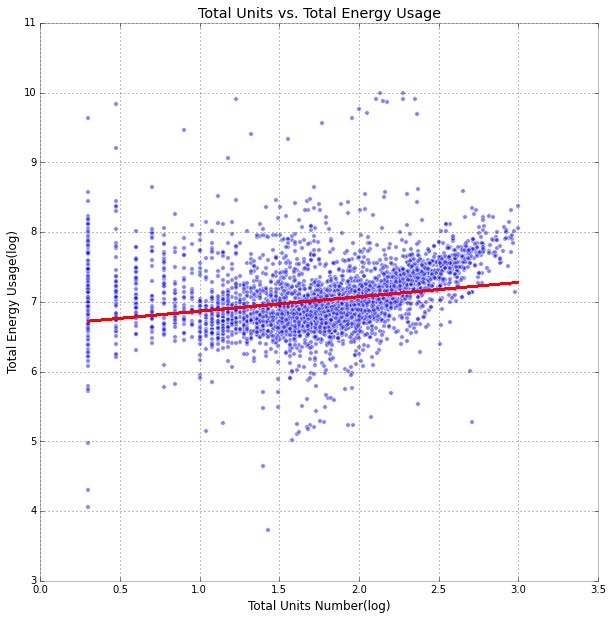

In [63]:
#fit and plots here

pl.figure(figsize=(10,10))
x = Unit_log 
y = Energy_log

xlabel('Total Units Number(log)')
ylabel('Total Energy Usage(log)')
pl.title('Total Units vs. Total Energy Usage')
pl.scatter(x, y, alpha=.5, s=20 )
pl.plot(x, fit.params[1]*x + fit.params[0], '-', color = 'r')
pl.show()

try making a fit for energy vs units AND a fit for units vs energy. 
tell me which is better. 

###Look at the fit summary: Which is better? Could you do a likelihood ratio test here? Why or why not??

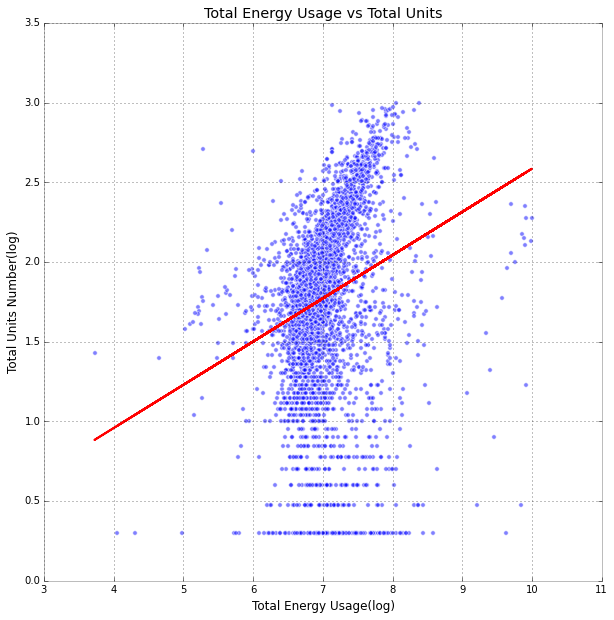

In [66]:
##Fit and plots here
pl.figure(figsize=(10,10))
x1 = Energy_log
y1 = Unit_log 
X = sm.add_constant(x1)

##Print X
model = sm.OLS(y1, X, missing='drop') # ignores entires where x or y is NaN
fit = model.fit()
fit.params[1], fit.params[0] # could also return stderr in each via fit.bse

ylabel('Total Units Number(log)')
xlabel('Total Energy Usage(log)')
pl.title("Total Energy Usage vs Total Units")
pl.scatter(x1, y1, alpha=.5, s=20 )
pl.plot(x1, fit.params[1]*x1 + fit.params[0], '-', color = 'r')
pl.show()

####Look at the fit summary: which is better? Could you do a likelihood ratio test here? Why or why not??
I found the plot of Total Units vs. Total Energy is better. We can't do a likelihood ration test here because the degree freedom is zero.

##Now fit a second degree curve to it: a*x^2+b*x+c. 
That is still called a linear fir by the way, the "linear" definition refers to the PARAMETERS being linear, not to the variable!
you can use np.polyfit for example (an example showned in the other assignment notebook), with order 2 instead of 1,

np.polyfit(x, y, 2)

or statmodels.formula.api passing a formula like 

formula = 'y ~ 1 + x + I(x ^ 2.0)'

[ 0.43069067 -1.15982073  7.60731462]


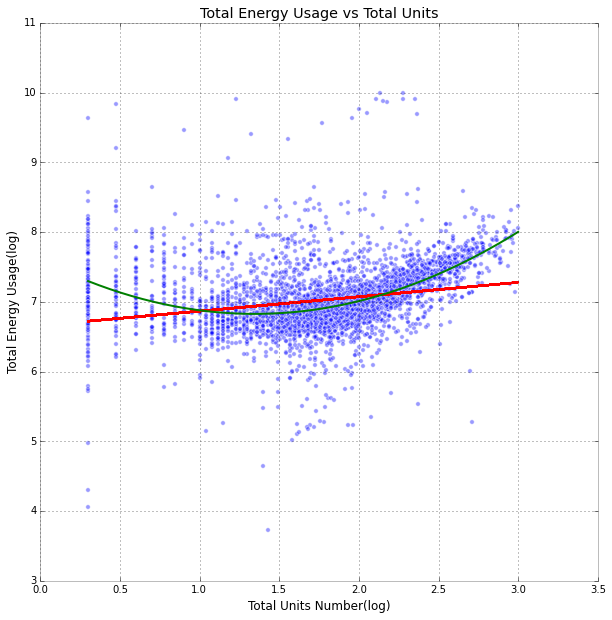

In [88]:
#fit and plots here
pl.figure(figsize=(10,10))
x = Unit_log 
y = Energy_log

X = sm.add_constant(x)
#print X
model = sm.OLS(y, X, missing='drop') # ignores entires where x or y is NaN
fit = model.fit()
fit.params[1], fit.params[0]

coefficient = np.polyfit(x,y,2)
p = np.poly1d(coefficient)
X = np.linspace(x.min(), x.max(),200)
Y = p(X)

print coefficient



xlabel('Total Units Number(log)')
ylabel('Total Energy Usage(log)')
pl.title("Total Energy Usage vs Total Units")
pl.scatter(x, y, alpha=.4, s=20 )
pl.plot(x, fit.params[1]*x + fit.params[0], '-',  color = 'r')
pl.plot(X,Y,color = 'g')
pl.show()

#### EXTRA CREDIT: 
    
Use WLS the weighted sq fit instead of OLS. you need to give weights to your points: 
estimates of the errors. the easiest thing is the sqrt of the datapoint value.
if you want to be more sophisticated you can estimate the variance of your data
near each point and use that 

Lastly: do it by hand and create a function that minimizes the residuals: 
       
the residuals are the sum of the differences between data and model: 
in the case of a line fit model (and you can use your errors if you did the extra credit!)

sum(np.log(bblnrgdatacut.nrg) - np.log(bblnrgdatacut.UnitsTotal)*a+b )^2

where a and b are the parameters returned by the line fitter. 
for each data point you can calculate the model at different values : for example in a range B = np.arange (-100, 100, 1) for the intercept, and A = np.arange(-50.0, 50.0, 0.5) for the slope

write it as a nested for loop (or challenge yourself and vectorize it!) with a loop inside another ranging all poissible combinations of the 2 variables (i use enumerate to get both an index from 0 to the size of my array, which i assign to i (and j) and the value of the array at that index - look up the syntax!):


for i,a in enumerate(A):

    for j,b in enumerate(B):
    
         Lsurface[i][j].....

this gives you a 2D array that represents your likelihood surface! what we do to find a good fit is find the minimum (lowest point) on this surface. 

you can plot a surface (a 2D array) with pl.imshow(Lsurface) as a "heatmap"

but when you do that you will find that the plot is very uninformative. just like you did before with the data, plot the log of it (pl.imshow(np.log(Lsurface))
and see if it helps!
also make sure your x and y axes tick numbers represent the range of values, not the cell index, which is the default for imshow. do that with the keyword extent: 
pl.imshow(Lsurface, .... , extent = [minimum, and max of your y array, minimum, and max of your x array]...) (notice that the numbers are switched! make sure to verify which axis is the slope, which is the intercept)

In [ ]:
##create the array
##[...]
##pl.figure(figsize=(10,10))
##pl.title ("log likelihood surface", fontsize = 22)
##pl.imshow(np.log(Lsurface), extent = ..., aspect=...)
##[...]
##pl.colorbar()

EXTRA CREDIT: get creative with the dataset! can you make an insigntful plot to show any structure in the data?
    
below is my silly attempt at that




In [ ]:
bblnrgdatacut['YearBuilt'][bblnrgdatacut['YearBuilt']<1800]=1800

bblnrgdatacut.plot(kind='scatter',x='nrg',y='UnitsTotal', fontsize=22, colormap='gist_rainbow', alpha = 1, marker='o',  figsize=(16, 14), loglog=True,  xlim=(1000,1e11), ylim=(1,1000), c=bblnrgdatacut['YearBuilt']-1900, s=bblnrgdatacut['UnitsTotal']/bblnrgdatacut['UnitsRes']*100)